**Chapter 9 – Up and running with TensorFlow**

_This notebook contains all the sample code and solutions to the exercises in chapter 9._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Creating and running a graph

### Building and running a computation graph 
* Computation unit
* It represents the ML model and the computations required to train it
 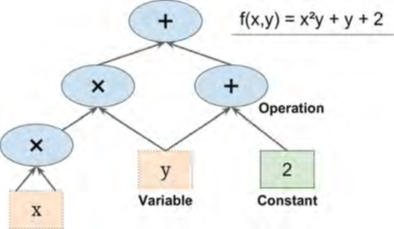

In [ ]:
import tensorflow as tf

x = tf.Variable(3, name="x") # define variable x initialized by 3
y = tf.Variable(4, name="y") # define variable y initialized by 4
f = x*x*y + y + 2

In [ ]:
x, y, f

In [ ]:
print(x, y, f)

In [ ]:
tf.print(x, y, f)

# Linear Regression

## Using the Normal Equation

TensorFlow operations (also called ops for short) can take any number of inputs and produce any number of outputs. 
For example, the addition and multiplication ops : two inputs and one output. 
Constants and variables : no input (source ops). 

The inputs and outputs can be multidimensional arrays, called tensors (hence the name “tensor flow”). 
Just like NumPy arrays, tensors have a type and a shape. (in the Python API, tensors are simply represented by NumPy ndarrays - typically floats, but can be strings (arbitrary byte arrays)).

TensorFlow will automatically run this on your GPU card if you have one

In [ ]:
import numpy as np
from sklearn.datasets import fetch_california_housing 

housing = fetch_california_housing() # fetching the dataset
m, n = housing.data.shape
tf.print(m,n)
# adds an extra bias input feature (x0 = 1) to all training instances
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]  # using NumPy, so it runs immediately

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X") # creates TensorFlow constant nodes, X to hold data 
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y") # creates TensorFlow constant nodes, y to hold targets
XT = tf.transpose(X)
#theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y) # Normal Equation
theta = tf.linalg.matmul(tf.linalg.matmul(tf.linalg.inv(tf.linalg.matmul(XT, X)), XT), y)
tf.print(theta)


Compare with pure NumPy

In [ ]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

Compare with Scikit-Learn

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

## Using Batch Gradient Descent

Gradient Descent requires scaling the feature vectors first using TF or Scikit-Learn.

In [ ]:
# Scikit-Learn example of scaling (or normalization)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Normalized data
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [ ]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape) # m.n

### Manually computing the gradients

In [ ]:

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X") # training data
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y") # labeled data

# random_uniform() function creates a node in the graph that will generate a tensor containing random values, 
# given its shape and value range, much like NumPy’s rand() function

theta = tf.Variable(tf.random.uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta") # weights
y_pred = tf.matmul(X, theta, name="predictions")  # Feedforward results
error = y_pred - y
gradients = 2/m * tf.matmul(tf.transpose(X), error)

# In this case, it implements the Batch Gradient Descent step θ(next step) = θ – η∇θMSE(θ).

for epoch in range(n_epochs):
    if epoch % 100 ==0:
        mse = tf.reduce_mean(tf.square(error), name="mse")
        tf.print("Epoch", epoch, "MSE =", mse)
    y_pred = tf.matmul(X, theta, name="predictions")
    error = y_pred - y
    gradients = 2/m * tf.matmul(tf.transpose(X), error)    
    theta= theta - learning_rate * gradients
tf.print(theta)

### Using autodiff

The preceding code requires mathematically deriving the gradients from the cost function (MSE)

Could use symbolic differentiation to automatically find the equations for the partial derivatives, but the resulting code would not necessarily be very efficient.

Use TensorFlow’s autodiff feature comes to the rescue: it can automatically and efficiently compute the gradients for you

Same as above except for the `gradients = ...` line:

In [ ]:

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")


In [ ]:
# Using TensorFlow’s autodiff
tf.random.set_seed(42)
theta = tf.Variable(tf.random.uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
with tf.GradientTape(persistent=True) as tape:
    tape.watch(theta)
    y_pred = tf.matmul(X, theta, name="predictions")
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

grads = tape.gradient(mse, theta)
theta=theta - learning_rate * grads

tf.print(mse)
tf.print(theta)

The gradients() function takes an op (mse) and a list of variables (theta), 
and it creates a list of ops (one per variable). 
So the gradients node will compute the gradient vector of the MSE with regards to theta.

In [ ]:
tf.random.set_seed(42)
theta = tf.Variable(tf.random.uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")

for epoch in range(n_epochs):
    if epoch % 100 == 0:
        tf.print("Epoch", epoch, "MSE =", mse)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(theta)
        y_pred = tf.matmul(X, theta, name="predictions")
        error = y_pred - y
        mse = tf.reduce_mean(tf.square(error), name="mse")

    grads = tape.gradient(mse, theta)
    theta=theta - learning_rate * grads

print("Best theta:")
tf.print(theta)

Example: How could you find the partial derivatives of the following function with regards to `a` and `b`?

Symbolic differentiation? -> don't even try. Headache.

In [ ]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

In [ ]:
my_func(0.2, 0.3)

In [ ]:
a = tf.Variable(0.2, name="a") #trainable
b = tf.Variable(0.3, name="b")
z = tf.constant(0.0, name="z0")


with tf.GradientTape() as tape:
    tape.watch([a, b])
    for i in range(100):
        z = a * tf.cos(z + i) + z * tf.sin(b - i)
    
grads = tape.gradient(z, [a, b])
tf.print(z)
tf.print(grads)


Let's compute the function at $a=0.2$ and $b=0.3$, and the partial derivatives at that point with regards to $a$ and with regards to $b$:

Main solutions to compute gradients automatically
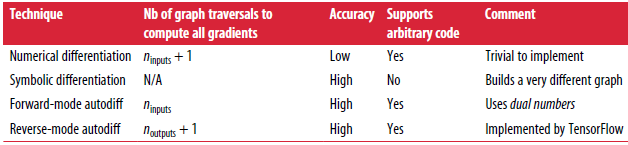

TensorFlow uses 'reverse-mode autodiff', which is perfect (efficient and accurate) when there are many inputs and few outputs, 
as is often the case in neural networks.

### Using a `GradientDescentOptimizer`

In [ ]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
tf.random.set_seed(42)
theta = tf.Variable(tf.random.uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
#y_pred = tf.matmul(X, theta, name="predictions")
#error = y_pred - y
#mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

In [ ]:
for epoch in range(n_epochs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(theta)
        y_pred = tf.matmul(X, theta, name="predictions")
        error = y_pred - y
        mse = tf.reduce_mean(tf.square(error), name="mse")
    if epoch % 100 == 0:
        tf.print("Epoch", epoch, "MSE =", mse)    
    grads = tape.gradient(mse, [theta])
    optimizer.apply_gradients(zip(grads,[theta]))

print("Best theta:")
tf.print(theta)
tf.print("MSE =", mse)

### Using a momentum optimizer

In [ ]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
tf.random.set_seed(42)
theta = tf.Variable(tf.random.uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
#y_pred = tf.matmul(X, theta, name="predictions")
#error = y_pred - y
#mse = tf.reduce_mean(tf.square(error), name="mse")

# Using momentum optimizer instead of Gradient Descent optimizer (Refer Chap. 10)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

Momentum optimizer usually gives out better results and fast. However, it does not sometimes. The results need to be compared with other optimizers.

In [ ]:
for epoch in range(n_epochs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(theta)
        y_pred = tf.matmul(X, theta, name="predictions")
        error = y_pred - y
        mse = tf.reduce_mean(tf.square(error), name="mse")
    if epoch % 100 == 0:
        tf.print("Epoch", epoch, "MSE =", mse)    
    grads = tape.gradient(mse, [theta])
    optimizer.apply_gradients(zip(grads,[theta]))

print("Best theta:")
tf.print(theta)
tf.print("MSE =", mse)

# Feeding data to the training algorithm
For Mini-batch Gradient Descent implementation, we need a way to replace X and y at every iteration with the next mini-batch 

## Mini-batch Gradient Descent

In [ ]:
#n_epochs = 1000
#learning_rate = 0.01

#X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
#y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

# define the batch size and compute the total number of batches
#batch_size = 10000
#n_batches = int(np.ceil(m / batch_size))
#tf.random.set_seed(42)
#theta = tf.Variable(tf.random.uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

In [ ]:
# fetch the mini-batches one by one, then provide the value of X and y via the feed_dict parameter when evaluating a node
# => load the data from disk
#def fetch_batch(epoch, batch_index, batch_size):
#    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
#    indices = np.random.randint(m, size=batch_size)  # not shown. generation of random number to select elements from training data
#    X_batch = tf.Variable(scaled_housing_data_plus_bias[indices], dtype=tf.float32, name="X_batch") # not shown
#    y_batch = tf.Variable(housing.target.reshape(-1, 1)[indices], dtype=tf.float32, name="y_batch") # not shown
#    return X_batch, y_batch

#for epoch in range(n_epochs):
#    for batch_index in range(n_batches): # one epoch
#        X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size) # one mini batch
#        with tf.GradientTape(persistent=True) as tape:
#            tape.watch(theta)
#            y_pred = tf.matmul(X_batch, theta, name="predictions")
#            error = y_pred - y_batch
#            mse = tf.reduce_mean(tf.square(error), name="mse")
#        grads = tape.gradient(mse, [theta])
#        optimizer.apply_gradients(zip(grads,[theta]))
#    if epoch % 10 == 0:
#        tf.print("Epoch", epoch, "MSE =", mse)     

In [ ]:
#print("Best theta:")
#tf.print(theta)
#tf.print("MSE =", mse)

### Practice
Increase n_epochs=1000 and modify above 2 cells so that it prints mse every 100 epochs and then print final theta.

# Saving and restoring a model
After training your model, you should save its parameters to disk to reuse them.
Or save checkpoints at regular intervals during training so that you can continue from the last checkpoint rather than start over from scratch

Create a Saver node at the end of the construction phase (after all variable nodes are created); 
then, in the execution phase, just call its save() method

In [ ]:
n_epochs = 1000                                                                       # not shown in the book
learning_rate = 0.01                                                                  # not shown

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            # not shown
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")          # not shown
tf.random.set_seed(42)
theta = tf.Variable(tf.random.uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")  # theta initialization  
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)            # not shown
#tf.print(export_dir)
for epoch in range(n_epochs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(theta)
        y_pred = tf.matmul(X, theta, name="predictions")
        error = y_pred - y
        mse = tf.reduce_mean(tf.square(error), name="mse")
    grads = tape.gradient(mse, [theta])
    optimizer.apply_gradients(zip(grads,[theta]))
    if epoch % 100 == 0:
        tf.print("Epoch", epoch, "MSE =", mse)
        tf.saved_model.save(theta, "./tmp/")
        
tf.saved_model.save(theta, "./tmp/final/")
    
# Results are saved at the files "/tmp/my_model.ckpt" at regular unterval and "/tmp/my_model_final.ckpt" as a final result.

In [ ]:
print("Best theta:")
tf.print(theta)
tf.print("MSE =", mse)

In [ ]:
imported = tf.saved_model.load("./tmp/final/")
tf.print(imported)
imported

In [ ]:
tf.math.equal(theta, imported) # compare the vectors

# Visualizing the graph
## inside Jupyter

To visualize the graph within Jupyter, we will use a TensorBoard server available online at https://tensorboard.appspot.com/ (so this will not work if you do not have Internet access).  As far as I can tell, this code was originally written by Alex Mordvintsev in his [DeepDream tutorial](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb). Alternatively, you could use a tool like [tfgraphviz](https://github.com/akimach/tfgraphviz).

In [ ]:
%load_ext tensorboard


## Using TensorBoard
If you feed it some training stats, it will display nice interactive visualizations of these stats in your web browser (e.g., learning curves). 
You can also provide it the graph’s definition and it will give you a great interface to browse through it.

1. To tweak your program a bit so it writes the graph definition and some training stats (for example, the training error (MSE)) to a log directory that TensorBoard will read from.
 - use a different log directory every time, or else TensorBoard will merge stats from different runs.
 - to include a timestamp in the log directory name

In [ ]:
# Add the following code at the beginning of the program
from datetime import datetime


In [ ]:
n_epochs = 1000
learning_rate1 = 0.01
learning_rate2 = 0.001
momentum1=0.9
momentum2=0.8

X = tf.Variable(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.Variable(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
tf.random.set_seed(42)
theta = tf.Variable(tf.random.uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
                                  # not shown
optimizer1 = tf.keras.optimizers.SGD(learning_rate=learning_rate1)
optimizer2 = tf.keras.optimizers.SGD(learning_rate=learning_rate1, momentum=momentum1)
optimizer3 = tf.keras.optimizers.SGD(learning_rate=learning_rate2, momentum=momentum2)


In [ ]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
summary_writer = tf.summary.create_file_writer(logdir)


In [ ]:
n_epochs = 10
#batch_size = 100
#n_batches = int(np.ceil(m / batch_size))
#batch_size1 = 50
#n_batches1 = int(np.ceil(m / batch_size1))

In [ ]:
tf.random.set_seed(42)
theta = tf.Variable(tf.random.uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
tf.print(theta)
for epoch in range(n_epochs):
#    for batch_index in range(n_batches): # one epoch
#        X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size) 
#        if batch_index % 10 == 0:
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(theta)
        y_pred = tf.matmul(X, theta, name="predictions")
        error = y_pred - y
        mse = tf.reduce_mean(tf.square(error), name="mse")
    grads = tape.gradient(mse, [theta])
    optimizer1.apply_gradients(zip(grads,[theta]))
    tf.print("Epoch", epoch, "MSE =", mse)
    with summary_writer.as_default():
        tf.summary.scalar('MSE', mse, step=epoch)
        summary_writer.flush()

In [ ]:
tf.print("MSE:", mse)
print("Best theta:")
tf.print(theta)

In [ ]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
summary_writer = tf.summary.create_file_writer(logdir)

In [ ]:
tf.random.set_seed(42)
theta = tf.Variable(tf.random.uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
tf.print(theta)
for epoch in range(n_epochs):
#    for batch_index in range(n_batches): # one epoch
#        X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size) 
#        if batch_index % 10 == 0:
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(theta)
        y_pred = tf.matmul(X, theta, name="predictions")
        error = y_pred - y
        mse = tf.reduce_mean(tf.square(error), name="mse")
    grads = tape.gradient(mse, [theta])
    optimizer2.apply_gradients(zip(grads,[theta]))
    tf.print("Epoch", epoch, "MSE =", mse)   
    with summary_writer.as_default():
        tf.summary.scalar('MSE', mse, step=epoch)
        summary_writer.flush()

In [ ]:
tf.print("MSE:", mse)
print("Best theta:")
tf.print(theta)

In [ ]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
summary_writer = tf.summary.create_file_writer(logdir)

In [ ]:
tf.random.set_seed(42)
theta = tf.Variable(tf.random.uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
tf.print(theta)
for epoch in range(n_epochs):
#    for batch_index in range(n_batches1): # one epoch
#        X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size1) 
#       if batch_index % 10 == 0:
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(theta)
        y_pred = tf.matmul(X, theta, name="predictions")
        error = y_pred - y
        mse = tf.reduce_mean(tf.square(error), name="mse")
    grads = tape.gradient(mse, [theta])
    optimizer3.apply_gradients(zip(grads,[theta]))
    tf.print("Epoch", epoch, "MSE =", mse)    
    with summary_writer.as_default():
        tf.summary.scalar('MSE', mse, step=epoch)
        summary_writer.flush()    

In [ ]:
tf.print("MSE:", mse)
print("Best theta:")
tf.print(theta)

In [ ]:
%tensorboard --logdir ./tf_logs


### Otherewise 

Open up a new shell and go to your working directory, then type 

cd tf_logs

ls -l

tensorboard --logdir ./ 

Create a new tab in your web browser, and enter the url "http://localhost:6006"

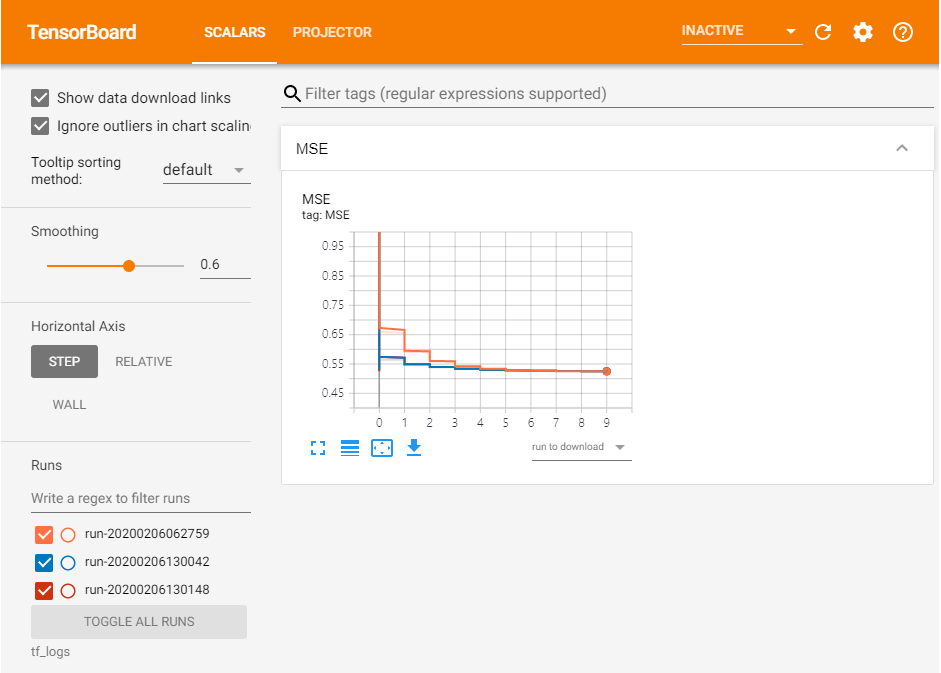

Click the graphs tab.

Double-click each node will expand the graphs

## Strings

In [ ]:

text = np.array("Do you want some café?".split())
text_tensor = tf.constant(text)

print(text_tensor)